In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import numpy as np
import random

In [ ]:
# Creating a DataFrame from the given data
# https://www.census.gov/data/tables/time-series/demo/popest/2020s-state-detail.html?utm_source=chatgpt.com
USA_2023_POPULATION_DATA = {
    "State": [
        "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "DC", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY",
        "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH",
        "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
    ],
    "Population": [
        3977628, 557899, 5848310, 2362124, 30519524, 4662926, 2894190, 819952, 552380, 18229883,
        8490546, 1141525, 1497384, 9844167, 5274945, 2476882, 2246209, 3509259, 3506600, 1146670,
        4818337, 5659598, 7925350, 4436981, 2259864, 4821686, 897161, 1497381, 2508220, 1150004,
        7280551, 1663024, 15611308, 8498868, 599192, 9207681, 3087217, 3401528, 10332678, 892124,
        4229354, 697420, 5555761, 22942176, 2484582, 532828, 6834154, 6164810, 1417859, 4661826, 454508
    ]
}

usa_2023_population_age_18_and_up_data_frame = pd.DataFrame(USA_2023_POPULATION_DATA)
display(usa_2023_population_age_18_and_up_data_frame.head(10))


,State,Population
0,AL,3977628
1,AK,557899
2,AZ,5848310
3,AR,2362124
4,CA,30519524
5,CO,4662926
6,CT,2894190
7,DE,819952
8,DC,552380
9,FL,18229883


In [ ]:
def create_map(df_loc, zoom=6, tiles='OpenStreetMap'):
    """
    Generate a Folium Map with clustered markers of accident locations.
    Automatically centers the map based on available locations in the dataset.
    """
    # Compute the mean latitude and longitude for centering the map
    mean_lat = df_loc['Start_Lat'].mean()
    mean_lng = df_loc['Start_Lng'].mean()

    # Create the map centered on the computed mean location
    state_map  = folium.Map(location=[mean_lat, mean_lng], zoom_start=zoom, tiles=tiles)

    # Add marker clustering
    marker_cluster = MarkerCluster().add_to(state_map)

    # Iterate over the DataFrame rows and add each marker to the cluster
    for idx, row in df_loc.iterrows():
        folium.Marker(
            location=[row['Start_Lat'], row['Start_Lng']],
            popup=f"Lat, Lng: {row['Start_Lat']}, {row['Start_Lng']}"
        ).add_to(marker_cluster)

    return state_map
 
def plot_stacked_bar_chart(data_frame):
    """
    Plots a stacked bar chart showing the distribution of accident severity across states.
    """
    # Count the number of accidents by state and severity
    severity_counts = data_frame.groupby(["State", "Severity"]).size().unstack(fill_value=0)

    # Define colors for different severity levels
    severity_colors = {1: "#66c2a5", 2: "#fc8d62", 3: "#8da0cb", 4: "#e78ac3"}

    # Plot the stacked bar chart
    severity_counts.plot(kind="bar", stacked=True, figsize=(14, 6), color=[severity_colors[i] for i in severity_counts.columns])

    # Chart formatting
    plt.title("Accident Severity Distribution Across States", fontsize=14)
    plt.xlabel("State", fontsize=12)
    plt.ylabel("Number of Accidents", fontsize=12)
    plt.xticks(rotation=90)  # Rotate x-axis labels for readability
    plt.legend(title="Severity Level")
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Show the plot
    plt.show()


# accedent_data_frame
def plot_stacked_bar_chart(accedent_data_frame, population_data_frame):

    # Count accidents per state per severity level
    severity_counts = accedent_data_frame.groupby(["State", "Severity"]).size().unstack(fill_value=0)
    
    # Merge with population data
    merged_df = population_data_frame.merge(severity_counts, on="State", how="left").fillna(0)
    
    # Define colors for severity levels
    severity_colors = {1: "#a6cee3", 2: "#1f78b4", 3: "#b2df8a", 4: "#33a02c"}

    # Plot stacked bar chart
    ax = merged_df.set_index("State")[sorted(severity_counts.columns)].plot(
        kind="bar", stacked=True, figsize=(14, 7), color=[severity_colors[s] for s in sorted(severity_counts.columns)]
    )

    # Labels and title
    plt.xlabel("State")
    plt.ylabel("Number of Accidents")
    plt.title("Stacked Bar Chart of Accidents per State by Severity Level")
    plt.xticks(rotation=45, ha="right")
    
    # Add legend
    plt.legend(title="Severity Level", loc="upper right")

    # Show plot
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()


def plot_bubble_chart(accedent_data_frame, population_data_frame):
    # Aggregate accident count and average severity per state
    accident_summary = accedent_data_frame.groupby("State").agg(
        Accidents=("State", "count"),
        Avg_Severity=("Severity", "mean")
    ).reset_index()

    # Merge with population data
    merged_df = pd.merge(accident_summary, population_data_frame, on="State")

    # Normalize population size for better bubble visualization
    pop_scaled = merged_df["Population"] / 50000  # Adjusting scale for better visibility

    # Create Bubble Chart
    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(
        merged_df["Population"], 
        merged_df["Accidents"], 
        s=pop_scaled,  # Bubble size based on population
        c=merged_df["Avg_Severity"],  # Color based on severity
        cmap="Reds", 
        alpha=0.7,
        edgecolors="k"
    )

    # Add state labels on each bubble
    for i, row in merged_df.iterrows():
        plt.text(row["Population"], row["Accidents"], row["State"], fontsize=10, ha='center', va='center', color="black")

    # Add color bar for severity
    cbar = plt.colorbar(scatter)
    cbar.set_label("Average Severity (1=Low, 4=High)")

    # Labels and title
    plt.xlabel("State Population")
    plt.ylabel("Number of Accidents")
    plt.title("Bubble Chart of Accidents vs. Population (Scaled by Population & Colored by Severity)")

    # Grid for better readability
    plt.grid(True, linestyle="--", alpha=0.6)

    # Show plot
    plt.show()


def plot_population_vs_accident_percentage(accedent_data_frame, population_data_frame):

    # Count total accidents per state and calculate severity average
    accident_summary = accedent_data_frame.groupby("State").agg(
        Accidents=("State", "count"),
        Avg_Severity=("Severity", "mean")
    ).reset_index()

    # Merge with population data
    merged_df = pd.merge(accident_summary, population_data_frame, on="State")

    # Calculate percentage of population involved in accidents
    merged_df["Accident_Percentage"] = (merged_df["Accidents"] / merged_df["Population"]) * 100

    # Create Scatter Plot
    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(
        merged_df["Accident_Percentage"], 
        merged_df["Avg_Severity"], 
        s=merged_df["Population"] / 50000,  # Bubble size based on population
        c=merged_df["Avg_Severity"],  # Color based on severity
        cmap="Reds", 
        alpha=0.7,
        edgecolors="k"
    )

    # Add state labels to each point
    for i, row in merged_df.iterrows():
        plt.text(row["Accident_Percentage"], row["Avg_Severity"], row["State"], fontsize=10, ha='right', va='center', color="black")

    # Add color bar for severity
    cbar = plt.colorbar(scatter)
    cbar.set_label("Average Severity (1=Low, 4=High)")

    # Labels and title
    plt.xlabel("Accident Percentage of State Population")
    plt.ylabel("Average Severity of Accidents")
    plt.title("Scatter Plot: Accident Percentage vs. Severity per State")

    # Grid for better readability
    plt.grid(True, linestyle="--", alpha=0.6)

    # Show plot
    plt.show()



def plot_paginated_accident_percentage_improved(accident_data_frame, population_data_frame, states_per_page=4):

    # Aggregate accident count per state and severity
    accident_summary = accident_data_frame.groupby(["State", "Severity"]).size().unstack(fill_value=0)

    # Merge with population data
    merged_df = population_data_frame.merge(accident_summary, on="State", how="left").fillna(0)

    # Calculate accident percentage per severity level
    for severity in sorted(accident_summary.columns):
        merged_df[f"Severity_{severity}_Percentage"] = (merged_df[severity] / merged_df["Population"]) * 100

    # Sort states by population (descending)
    merged_df = merged_df.sort_values(by="Population", ascending=False)

    # Define severity colors
    severity_colors = {1: "#a6cee3", 2: "#1f78b4", 3: "#b2df8a", 4: "#33a02c"}

    # Paginate the states into batches
    total_states = len(merged_df)
    for start in range(0, total_states, states_per_page):
        end = min(start + states_per_page, total_states)
        subset_df = merged_df.iloc[start:end]

        # Determine subplot grid size
        num_states = len(subset_df)
        cols = 2  # Maximum 2 columns for better readability
        rows = int(np.ceil(num_states / cols))  # Auto-adjust row count

        # Adjust figure size dynamically
        fig_height = max(4, rows * 2.5)  # Ensure proper spacing
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, fig_height))
        axes = np.array(axes).reshape(-1)  # Flatten for easy indexing

        # Generate bar plots for each state
        for idx, row in enumerate(subset_df.itertuples()):
            state = row.State
            population = row.Population
            severity_percentages = [getattr(row, f"Severity_{s}_Percentage") for s in sorted(accident_summary.columns)]

            # Plot bars
            bars = axes[idx].bar(
                sorted(accident_summary.columns),
                severity_percentages,
                color=[severity_colors[s] for s in sorted(accident_summary.columns)]
            )

            # Adjust y-axis limits to ensure no overlap
            max_percentage = max(severity_percentages) if severity_percentages else 0
            axes[idx].set_ylim(0, max_percentage * 1.3)  # Add space above bars

            # Add title with population info, ensuring no overlap with bars
            axes[idx].text(0.5, 1.15, f"{state}\nPop: {population:,}", fontsize=10, fontweight="bold",
                           ha='center', va='top', transform=axes[idx].transAxes)

            axes[idx].set_xlabel("Severity Level")
            axes[idx].set_ylabel("Accident % of Population")
            axes[idx].set_xticks(sorted(accident_summary.columns))

            # Add percentage annotations on bars with dynamic vertical placement
            for bar, percent in zip(bars, severity_percentages):
                height_adjustment = max_percentage * 0.05  # Adjust placement dynamically
                axes[idx].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + height_adjustment,
                               f"{percent:.2f}%", ha='center', va='bottom', fontsize=8, color="black")

        # Hide any unused subplots (if fewer states than grid size)
        for i in range(idx + 1, len(axes)):
            fig.delaxes(axes[i])

        # Show the current page of subplots
        plt.suptitle(f"Accident Percentage by Severity Level per State (Sorted by Population)\nPage {start // states_per_page + 1}", 
                     fontsize=14, fontweight="bold")
        plt.tight_layout()  # Ensures spacing is adjusted properly
        plt.show()


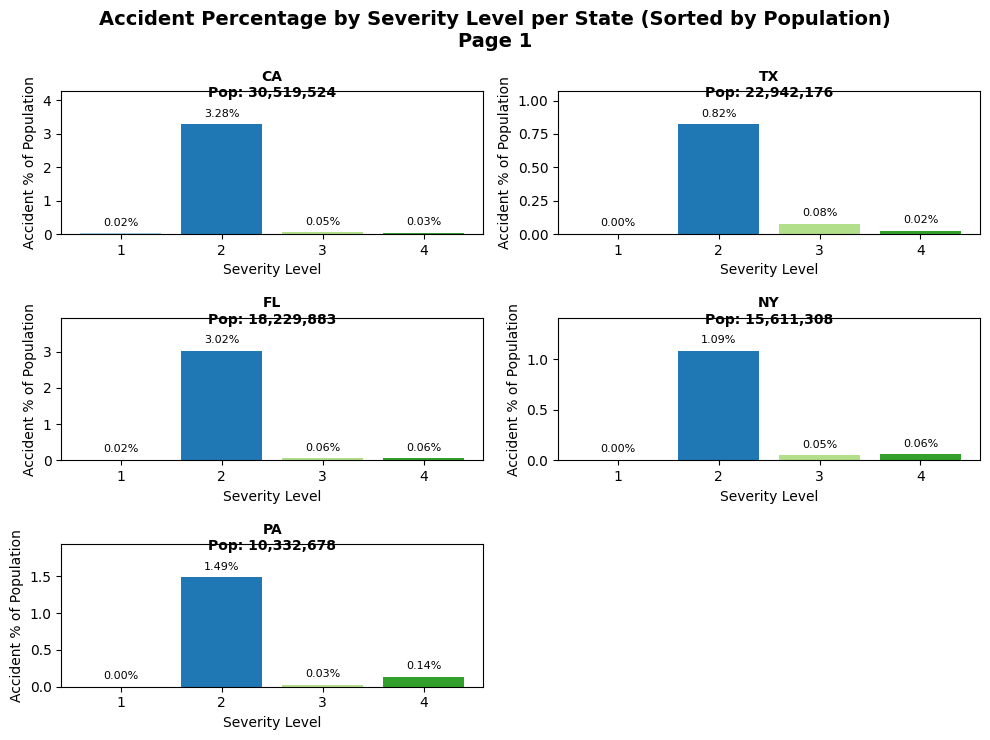

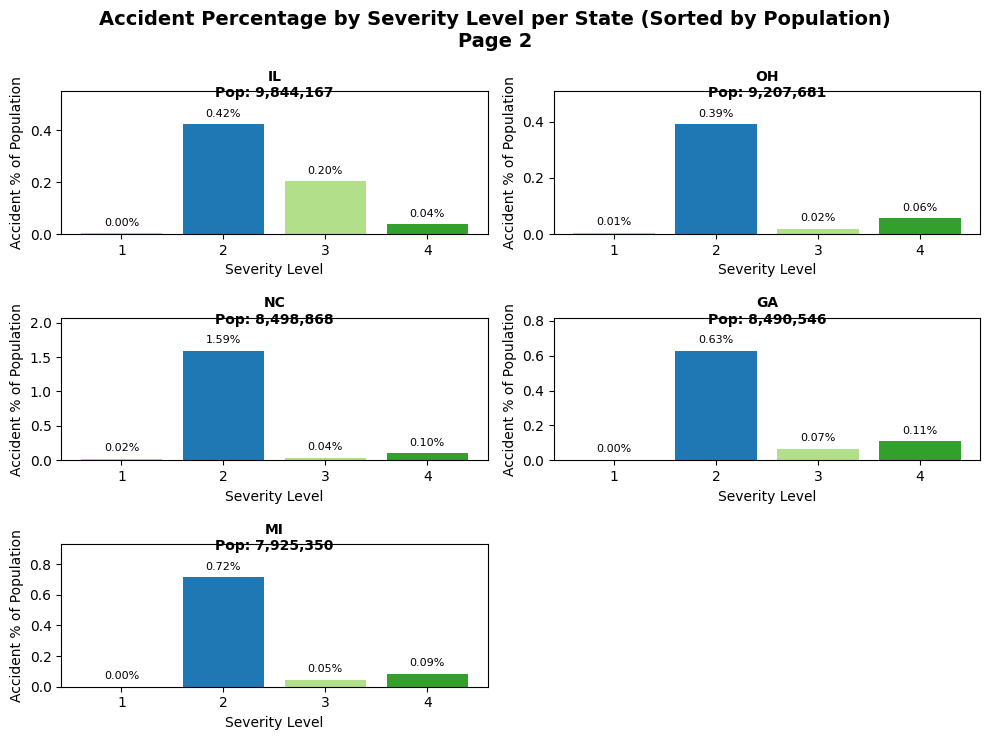

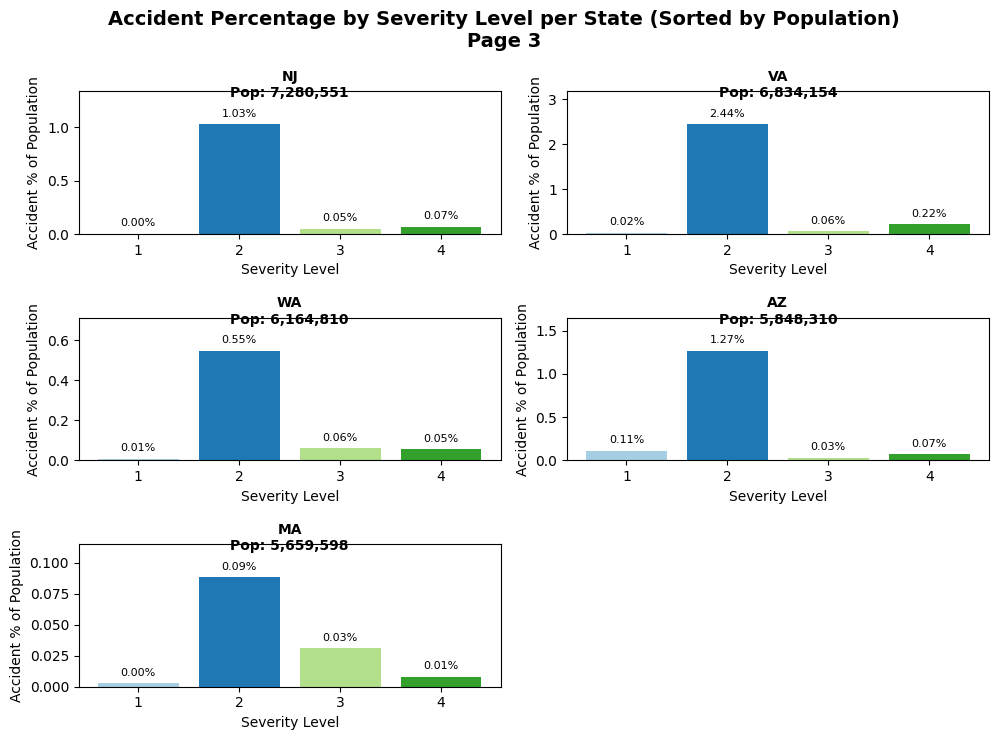

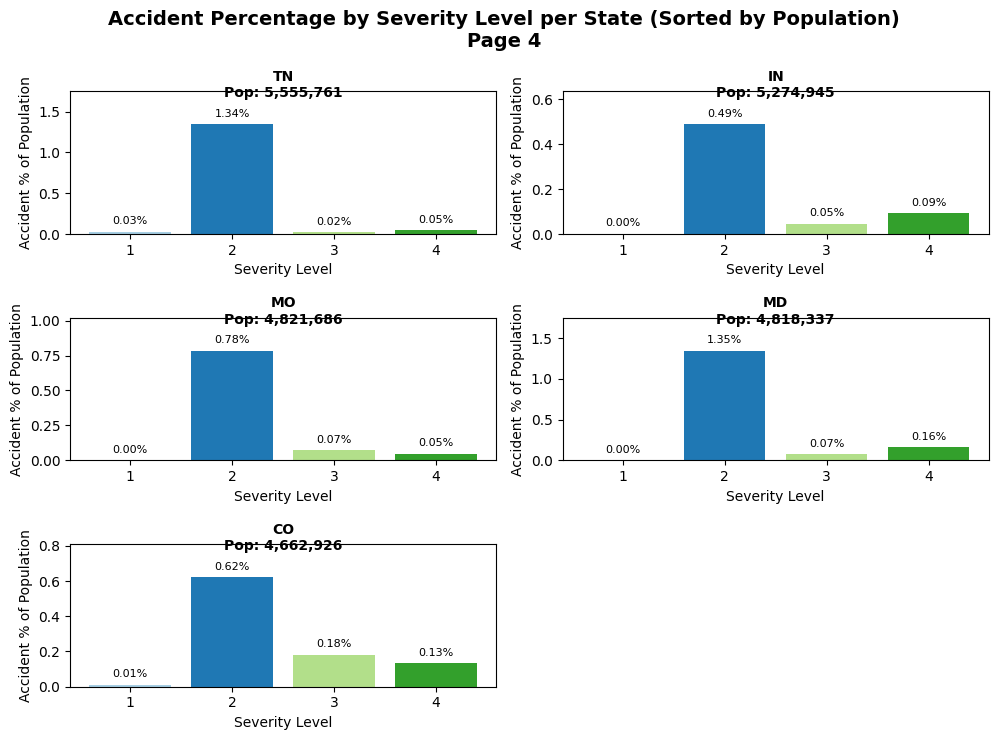

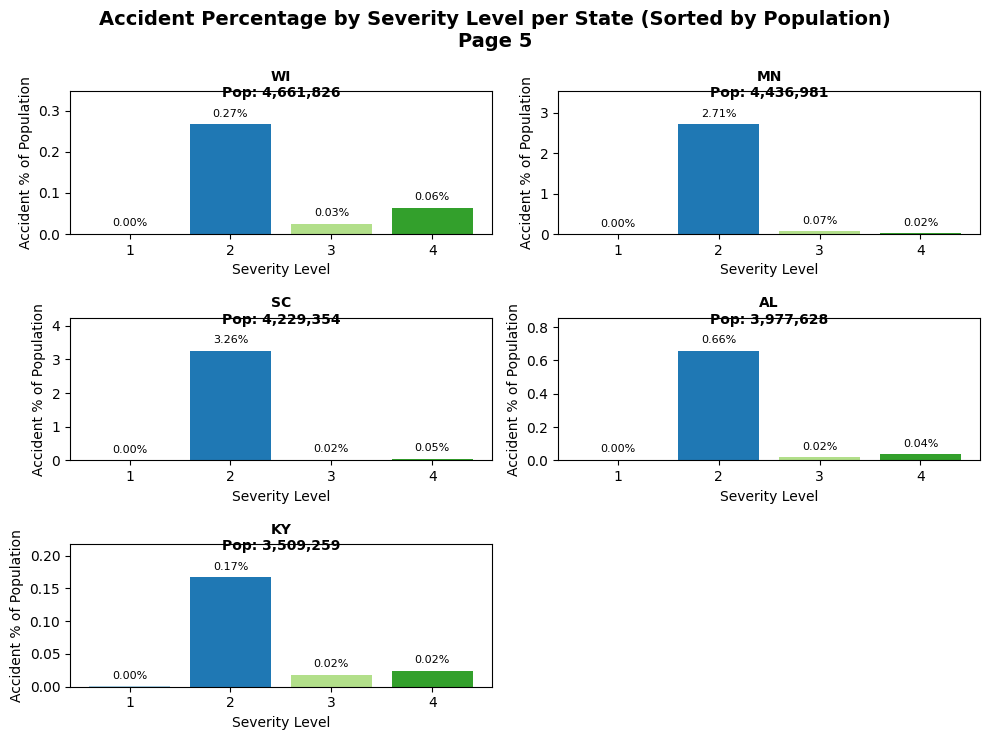

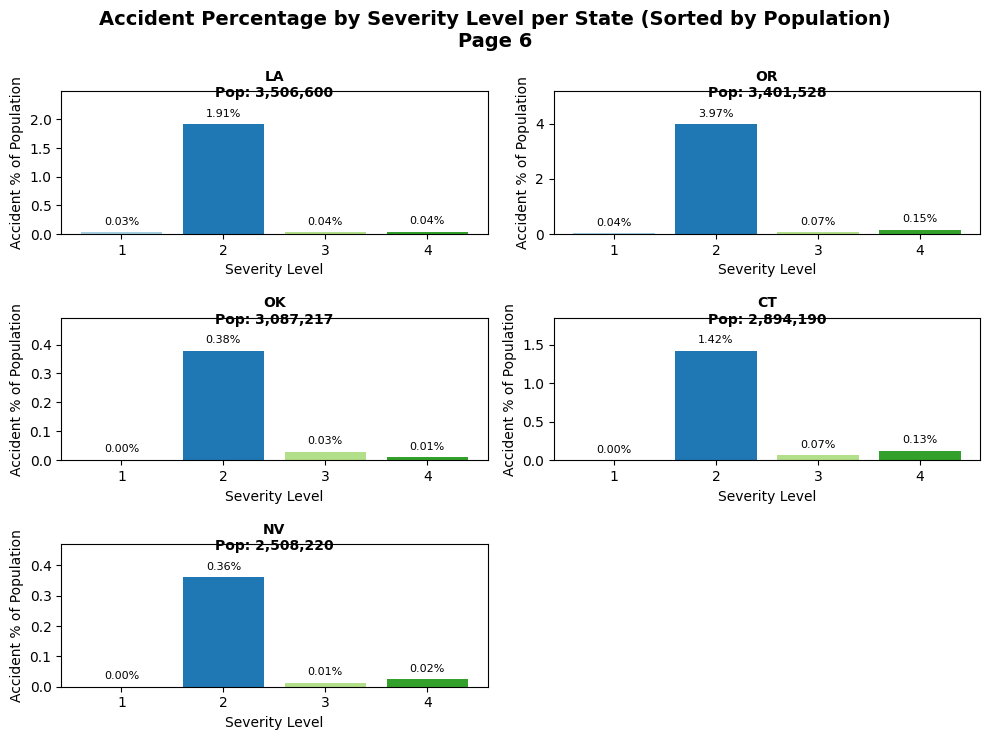

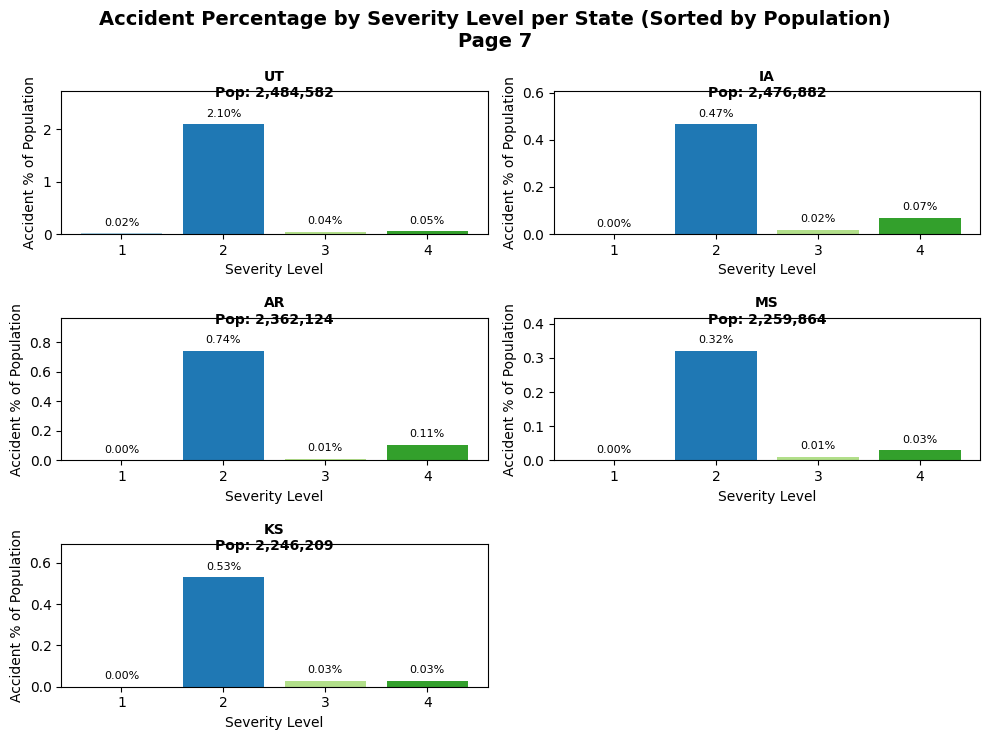

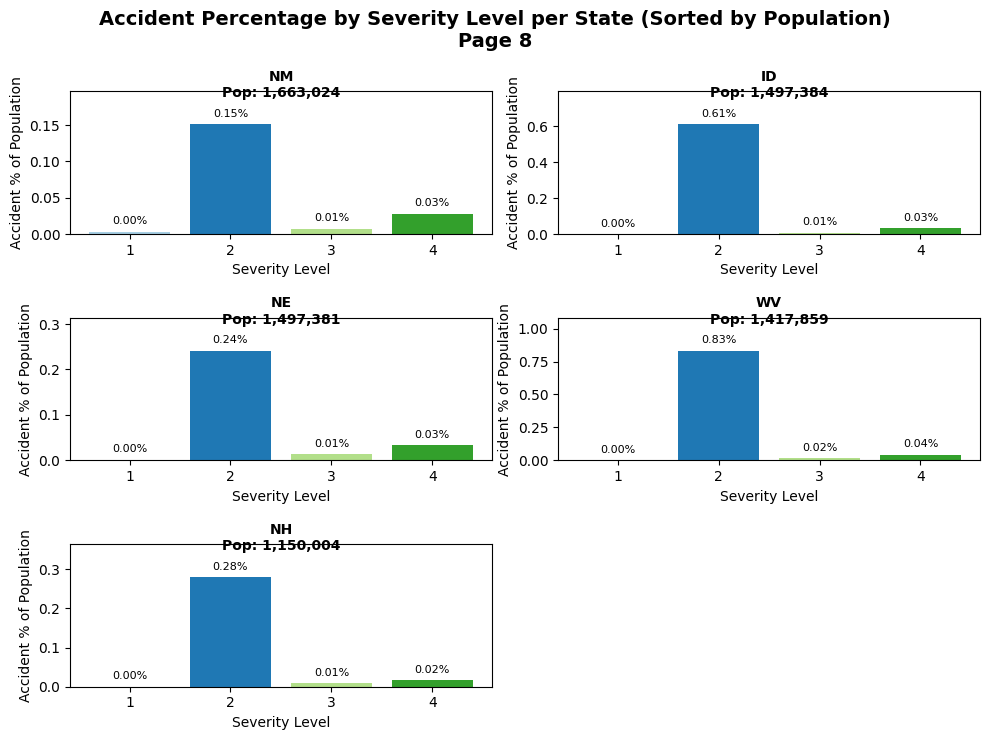

C:\Users\atul1\AppData\Local\Temp\ipykernel_32876\849097565.py:349: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



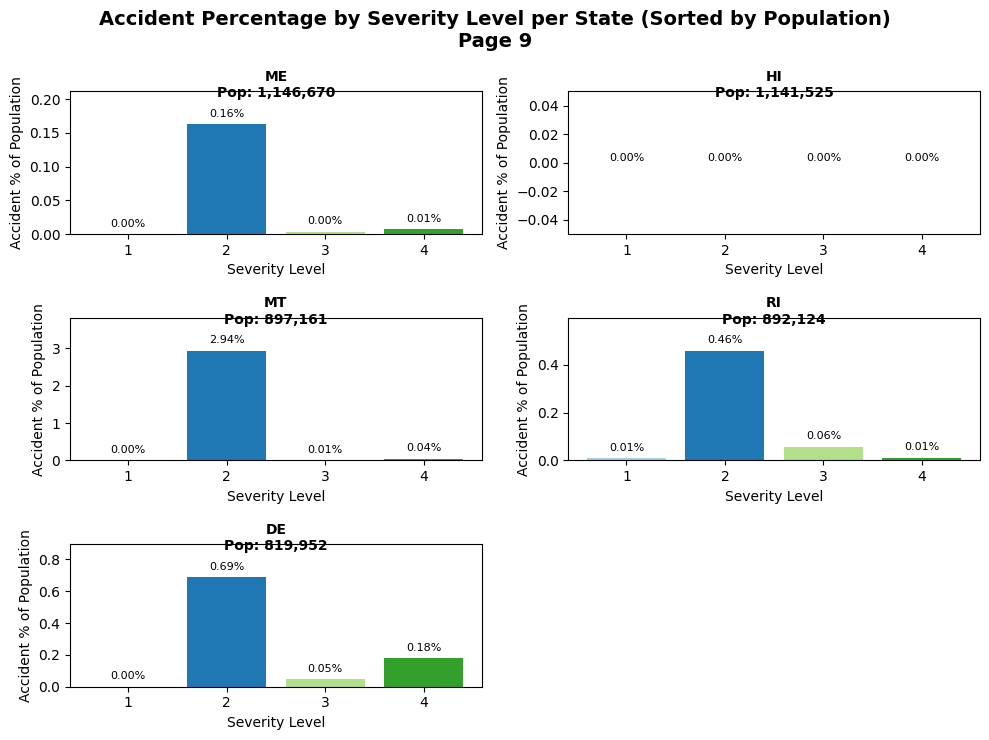

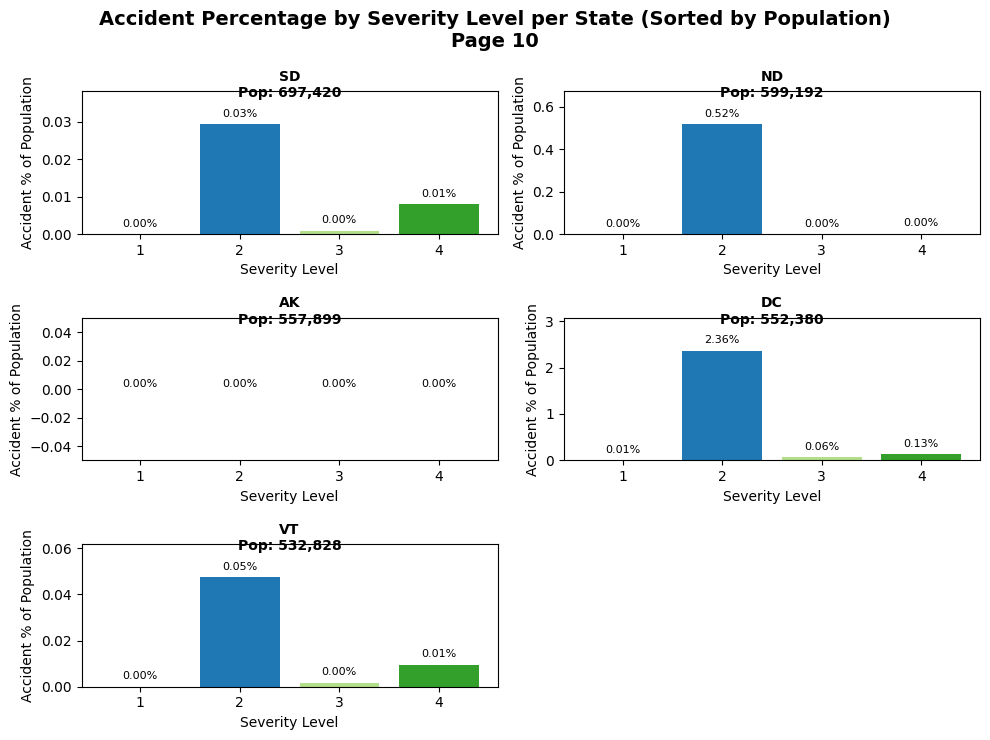

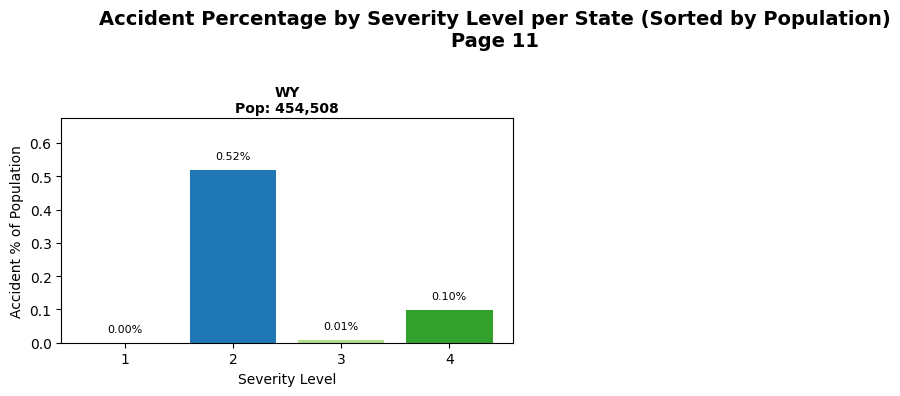

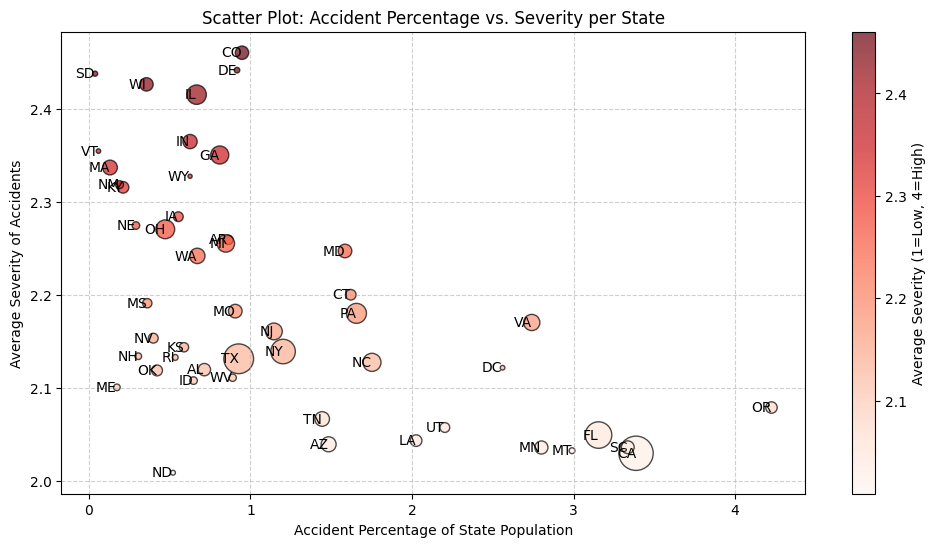

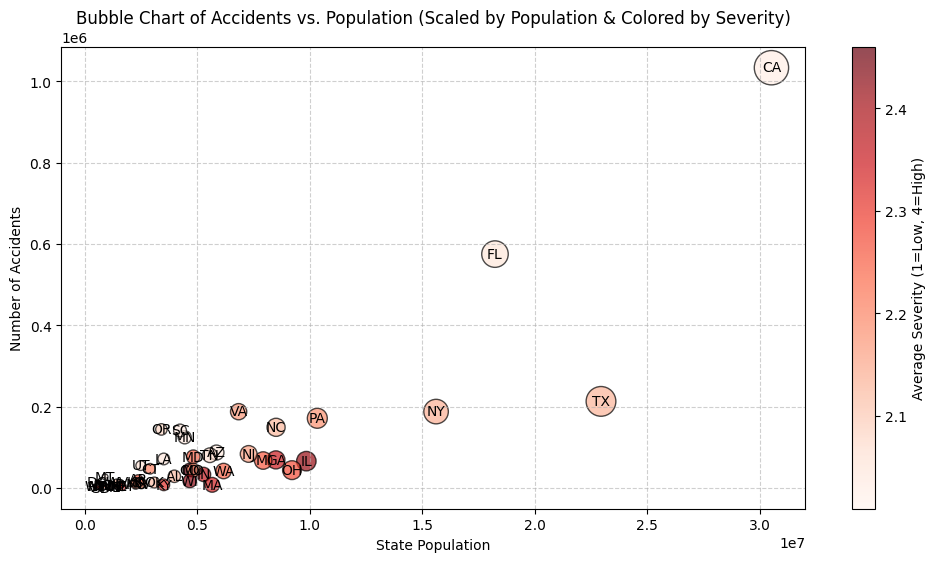

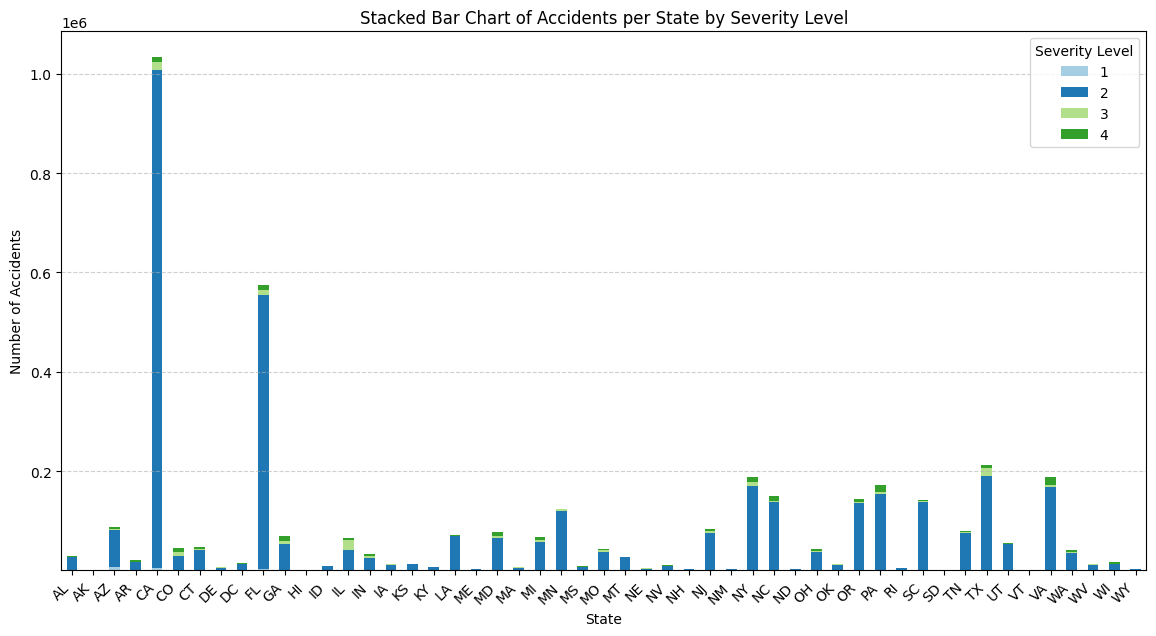

In [ ]:
plot_paginated_accident_percentage_improved(all_state_raw_data_file_frame, usa_2023_population_age_18_and_up_data_frame,5)
plot_population_vs_accident_percentage(all_state_raw_data_file_frame, usa_2023_population_age_18_and_up_data_frame)
plot_bubble_chart(all_state_raw_data_file_frame, usa_2023_population_age_18_and_up_data_frame)
plot_stacked_bar_chart(all_state_raw_data_file_frame, usa_2023_population_age_18_and_up_data_frame)